In [958]:
import pandas as pd
import numpy as np
import nltk
import re
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
import string
import re
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from scikitplot.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, LearningCurveDisplay, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import KMeans
from sklearn.model_selection import learning_curve 
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from spellchecker import SpellChecker
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report

# 1. Loading and Combining Datasets

In [959]:
df_1 = pd.read_excel('ISEP Sexist Data labeling.xlsx').rename(columns={'Sentences': 'Text'})
df_1.head()

,Text,Label
0,"For a woman, that is good",1
1,Just dress sexy and you will sign any contract.,1
2,Are you having period ?,1
3,Stop being bitchy,1
4,I leave early because of her children instead ...,1


In [960]:
df_1.shape

(1137, 2)

In [961]:
df_2 = pd.read_csv('sexism_data.csv').rename(columns={'text': 'Text', 'sexist':'Label'})
columns_to_drop = ['id','dataset','toxicity','of_id']
df_2 = df_2.drop(columns=columns_to_drop)
df_2.head()

,Text,Label
0,MENTION3481 i didn't even know random was an o...,False
1,Bottom two should've gone! #mkr,False
2,MENTION3111 MENTION3424 ladyboner deserves so ...,False
3,She shall now be known as Sourpuss #MKR #KatAn...,False
4,Tarah W threw a bunch of women under the bus s...,False


In [962]:
df_2['Label'] = df_2['Label'].astype(int)
df_2.head()

,Text,Label
0,MENTION3481 i didn't even know random was an o...,0
1,Bottom two should've gone! #mkr,0
2,MENTION3111 MENTION3424 ladyboner deserves so ...,0
3,She shall now be known as Sourpuss #MKR #KatAn...,0
4,Tarah W threw a bunch of women under the bus s...,0


In [963]:
df_2.shape

(13631, 2)

In [964]:
df_3 = pd.read_csv('final_labels.csv').rename(columns={'body':'Text','level_1': 'Label'})
columns_to_drop = ['entry_id', 'link_id', 'parent_id', 'entry_utc', 'subreddit', 'author',
                   'image', 'label_date', 'week', 'group', 'sheet_order', 'level_2', 'level_3',
                   'strength', 'highlight', 'split']
df_3 = df_3[df_3['Label'] != 'Nonmisogynistic']
df_3['Label'] = df_3['Label'].replace({'Misogynistic': 1})
df_3 = df_3.drop(columns=columns_to_drop)
df_3.head()

,Text,Label
4,"Damn, I saw a movie in which the old woman bat...",1
58,Okay but even if this wasn't a stupid hyperbol...,1
59,Okay but even if this wasn't a stupid hyperbol...,1
95,> The problem is that they removed the urinals...,1
96,But using the urinals in front of girls that a...,1


In [965]:
df_3.shape

(699, 2)

In [966]:
df_4 = pd.read_excel('classified_tweets.xltx', header=0).rename(columns={'text':'Text'})
df_4['Label'] = df_4['Label'].replace({2: 1})
df_4.head()

,Text,Label
0,whooo. did you have to choke a bitch?,1
1,im horny god damn porn fuck eon now I need rea...,1
2,Ya know you can take full credit for memeing ...,1
3,Clearly. Decepticonian bitch. Or at least inco...,1
4,LMAO. I was very confused. What a bitch she is.,1


In [967]:
df_4.shape

(1733, 2)

In [968]:
df_5 = pd.read_csv('CMSB_only_positive.csv').rename(columns={'label_sexist': 'Label','text':'Text'})
df_5['Label'] = df_5['Label'].replace({'sexist': 1})
df_5.head()

,Text,Label
0,MENTION1266 by her saying anything a man can d...,1
1,RT MENTION1004 Go ahead and call me sexist but...,1
2,honestly women can't drive as well as men.,1
3,women bus drivers are SO much nicer than men!,1
4,Men should always take the initiative when it ...,1


In [969]:
df_6 = pd.read_csv('english_all.csv').rename(columns={'label_sexist': 'Label', 'text':'Text'})
df_6 = df_6[df_6['Label'] != 'not sexist']
df_6['Label'] = df_6['Label'].replace({'sexist': 1})
df_6.head()

,Text,Label
6,@oviedohec seriously pio? ⁇ ⁇ ⁇ ⁇ ⁇ ...,1
10,"@ana_torroja menudo coñazo, you fight like a w...",1
13,you cannot dress like that. do you want to pro...,1
14,#rizhoma hotel 'a bridge for what is going on....,1
15,@gestionpe women at the wheel constant danger:...,1


In [970]:
df_7 = pd.read_excel('sexist_data.xlsx')
df_7.head()

,Text,Label
0,Yep just like triffeling women weaponized thei...,1
1,As a white male in this era I'm just scared t...,1
2,I heard that received some Shush/Slush mone...,1
3,She sounds like one horny bitch! Why it is alw...,1
4,When women stop performing in a provacative wa...,1


In [971]:
data_frames = [df_1, df_2, df_3, df_4, df_5, df_6, df_7]
combined_df = pd.concat(data_frames, ignore_index=True)

combined_df.head()

,Text,Label
0,"For a woman, that is good",1
1,Just dress sexy and you will sign any contract.,1
2,Are you having period ?,1
3,Stop being bitchy,1
4,I leave early because of her children instead ...,1


#### Changed all text in the 'Label' section to 1: converted categorical target labels to numerical form. so the text is in a more balanced state

In [972]:
combined_df.shape

(23661, 2)

In [973]:
data_stats = pd.DataFrame(combined_df['Label'].value_counts()).rename(columns={'Label': 'Counts'})
data_stats['%'] = round(data_stats['Counts']*100/data_stats['Counts'].sum(),2)
data_stats

,Counts,%
0,12335,52.13
1,11326,47.87


#### Have to make sure the data is equal or somewhat equal for accurate results

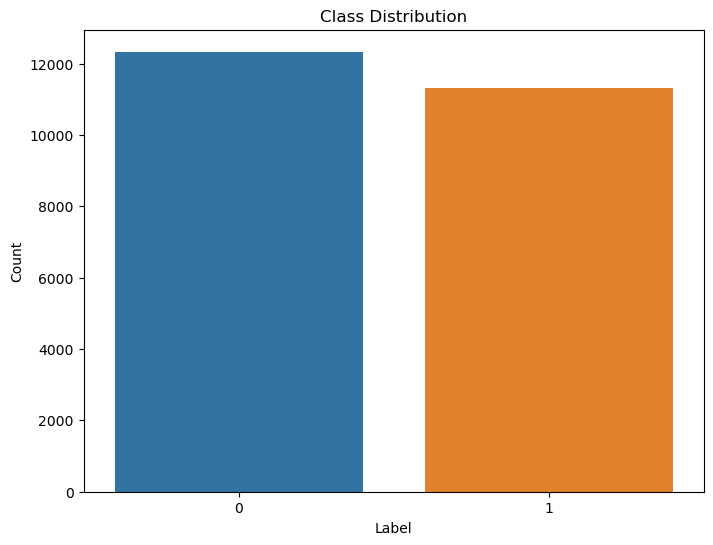

In [974]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.countplot(data=combined_df, x='Label')
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# 1.1 Preprocessing

In [975]:
def remove_punctuation(text):
    if isinstance(text, str): 
        translator = str.maketrans('', '', string.punctuation)
        return text.translate(translator)
    else:
        return str(text) 

combined_df['cleaned_text'] = combined_df['Text'].apply(remove_punctuation)

#### Removes all punctuation

In [976]:
def remove_spec_char(text):
    text = re.sub(r'[^a-z\s]', ' ', text)
    return text

#### Removes numbers from the text

In [977]:
lemon = WordNetLemmatizer()
def lemon_text(text):
    text = text.lower()
    words = text.split()
    
    lemoned_words = [lemon.lemmatize(word) for word in words]
    return ' '.join(lemoned_words)

combined_df['lemon_text'] = combined_df['cleaned_text'].apply(lemon_text)

#### Makes sure the word is just the root of the word instead

In [978]:
def tokenize_text(text):
    return word_tokenize(text)

combined_df['tokenized_text'] = combined_df['lemon_text'].apply(tokenize_text) 

#### Breaks down a text into individual units, such as words. Converts raw text into a format that can be used by algorithms and models. 

In [979]:
stop_words = set(stopwords.words('english'))
len(stop_words)

179

#### Removes stop words to help remove noise from the data - i.e. words that are useless to us and have no effect on the result such as 'a' or 'the'

In [980]:
filtered_text = []
for tokens in combined_df['tokenized_text']:
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    if filtered_tokens == [] : 
        filtered_tokens = 'None'
    filtered_text.append(filtered_tokens)       

In [981]:
combined_df.head()

,Text,Label,cleaned_text,lemon_text,tokenized_text
0,"For a woman, that is good",1,For a woman that is good,for a woman that is good,"[for, a, woman, that, is, good]"
1,Just dress sexy and you will sign any contract.,1,Just dress sexy and you will sign any contract,just dress sexy and you will sign any contract,"[just, dress, sexy, and, you, will, sign, any,..."
2,Are you having period ?,1,Are you having period,are you having period,"[are, you, having, period]"
3,Stop being bitchy,1,Stop being bitchy,stop being bitchy,"[stop, being, bitchy]"
4,I leave early because of her children instead ...,1,I leave early because of her children instead ...,i leave early because of her child instead of ...,"[i, leave, early, because, of, her, child, ins..."


In [982]:
combined_df['filtered_text'] = filtered_text
combined_df = combined_df[combined_df['filtered_text']!= 'None']
combined_df.head(10)

,Text,Label,cleaned_text,lemon_text,tokenized_text,filtered_text
0,"For a woman, that is good",1,For a woman that is good,for a woman that is good,"[for, a, woman, that, is, good]","[woman, good]"
1,Just dress sexy and you will sign any contract.,1,Just dress sexy and you will sign any contract,just dress sexy and you will sign any contract,"[just, dress, sexy, and, you, will, sign, any,...","[dress, sexy, sign, contract]"
2,Are you having period ?,1,Are you having period,are you having period,"[are, you, having, period]",[period]
3,Stop being bitchy,1,Stop being bitchy,stop being bitchy,"[stop, being, bitchy]","[stop, bitchy]"
4,I leave early because of her children instead ...,1,I leave early because of her children instead ...,i leave early because of her child instead of ...,"[i, leave, early, because, of, her, child, ins...","[leave, early, child, instead, husband]"
5,You can thank the quotas,1,You can thank the quotas,you can thank the quota,"[you, can, thank, the, quota]","[thank, quota]"
6,She would never had get this job if she were n...,1,She would never had get this job if she were n...,she would never had get this job if she were n...,"[she, would, never, had, get, this, job, if, s...","[would, never, get, job, woman]"
7,That is a woman thing,1,That is a woman thing,that is a woman thing,"[that, is, a, woman, thing]","[woman, thing]"
8,You are too emotional,1,You are too emotional,you are too emotional,"[you, are, too, emotional]",[emotional]
9,You have to wear a dress,1,You have to wear a dress,you have to wear a dress,"[you, have, to, wear, a, dress]","[wear, dress]"


In [983]:
from nltk.tokenize import word_tokenize

corpus = []
for text in combined_df['lemon_text']:
    words = word_tokenize(text)  
    corpus.append(words)

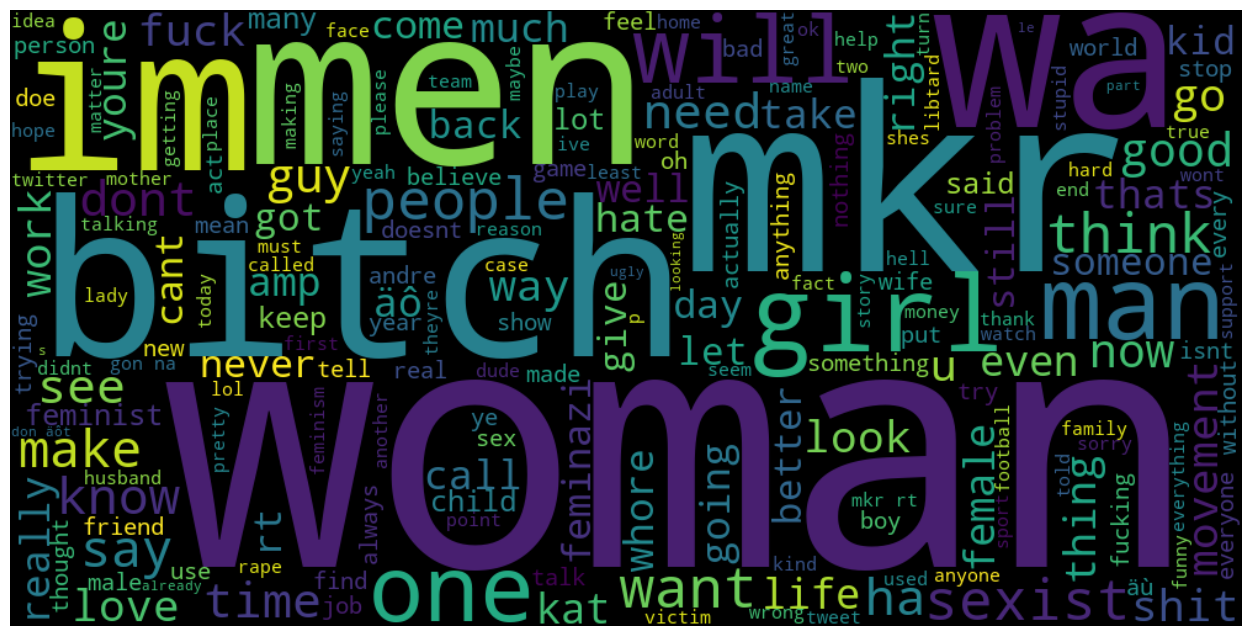

In [984]:
word_cloud = ' '.join([' '.join(words) for words in corpus])

wordcloud = WordCloud(width=1000, height=500, background_color='black', min_font_size=10).generate(word_cloud)

plt.figure(figsize=(20, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()

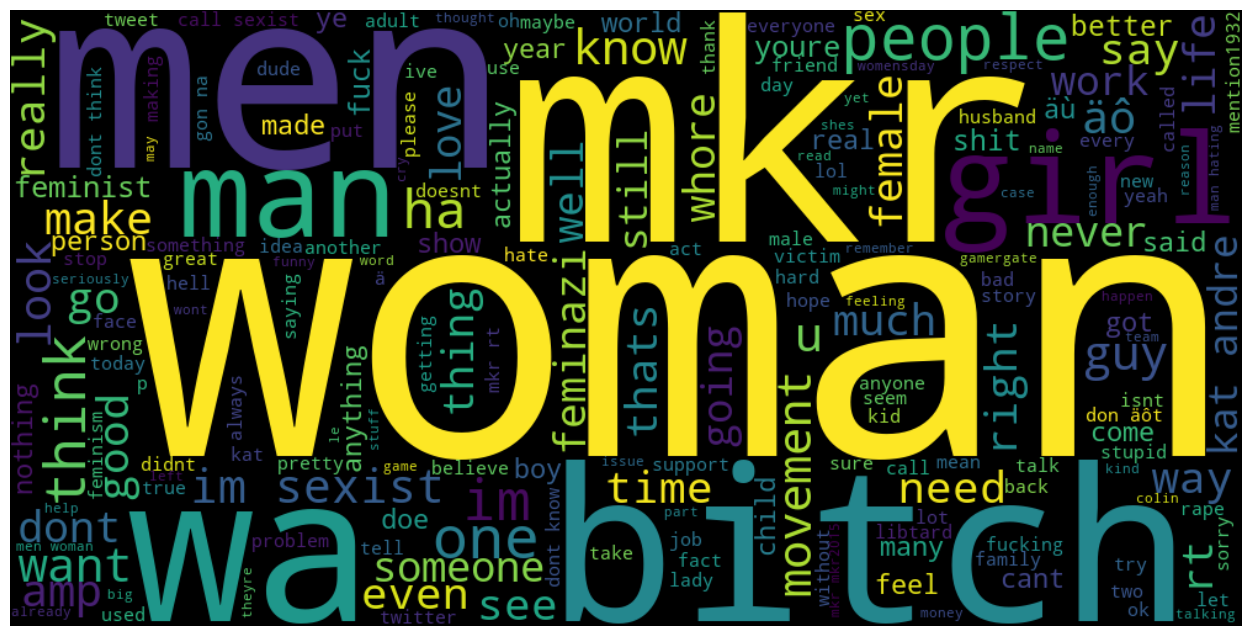

In [985]:
filtered_text_str = ' '.join([' '.join(words) for words in filtered_text])

wordcloud = WordCloud(width=1000, height=500, background_color='black', min_font_size=10).generate(filtered_text_str)

plt.figure(figsize=(20, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()

# 1.2 Splitting Dataset

In [986]:
train_df, test_df = train_test_split(combined_df, test_size= 0.2, random_state=42)

print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (18927, 6)
Test set shape: (4732, 6)


# 1. Count Vectorisation 

In [987]:
from sklearn.feature_extraction.text import CountVectorizer

In [988]:
def convert_to_string(list):
    return ' '.join(list)
train_df['sentence'] = train_df['filtered_text'].apply(convert_to_string)
test_df['sentence'] = test_df['filtered_text'].apply(convert_to_string)
max_features = 500
cv = CountVectorizer(ngram_range=(1,3), max_features=max_features)

X_train = cv.fit_transform(train_df['sentence']).toarray()
X_test = cv.transform(test_df['sentence']).toarray()

y_train = train_df['Label']
y_test = test_df['Label']

In [989]:
import time
import datetime

# 1.1 Classifiers for Count Vectorisation

## 1.1.1. Random Forest for Count Vectorisation - with ngrams

In [990]:
start_time = time.time()
params = {'n_estimators': [50, 100],
          'max_depth': [10, 15, 20],
          'min_samples_split': [5, 10],
          'min_samples_leaf': [2, 5],
          'bootstrap': [True, False]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), cv=5, param_grid=params)
grid_rf.fit(X_train, train_df['Label'])
grid_rf.best_params_
run_time = time.time() - start_time
print('Running time: %s' % datetime.timedelta(seconds = run_time))

Running time: 0:19:14.179301


In [991]:
rf_classifier = grid_rf.best_estimator_
best_params  = grid_rf.best_params_
train_pred_rf = rf_classifier.predict(X_train)
test_pred_rf = rf_classifier.predict(X_test)

train_accuracy = accuracy_score(train_df['Label'], train_pred_rf)
test_accuracy = accuracy_score(test_df['Label'], test_pred_rf)

classification_rep = classification_report(test_df['Label'], test_pred_rf)

print("\nRF best params:", best_params)

print("\nRF Training Accuracy:", np.round(train_accuracy * 100, 2), "%")
print("\nRF CV Accuracy:", np.round(np.median(grid_rf.best_score_) * 100, 2), "%")
print("\nRF Test Accuracy:", np.round(test_accuracy * 100, 2), "%")

print("\nRF Classification Report:")
print(classification_rep)


RF best params: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}

RF Training Accuracy: 84.65 %

RF CV Accuracy: 83.84 %

RF Test Accuracy: 83.52 %

RF Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.85      2451
           1       0.86      0.78      0.82      2281

    accuracy                           0.84      4732
   macro avg       0.84      0.83      0.83      4732
weighted avg       0.84      0.84      0.83      4732



Text(0.5, 1.0, 'Learning Curve for RandomForestClassifier')

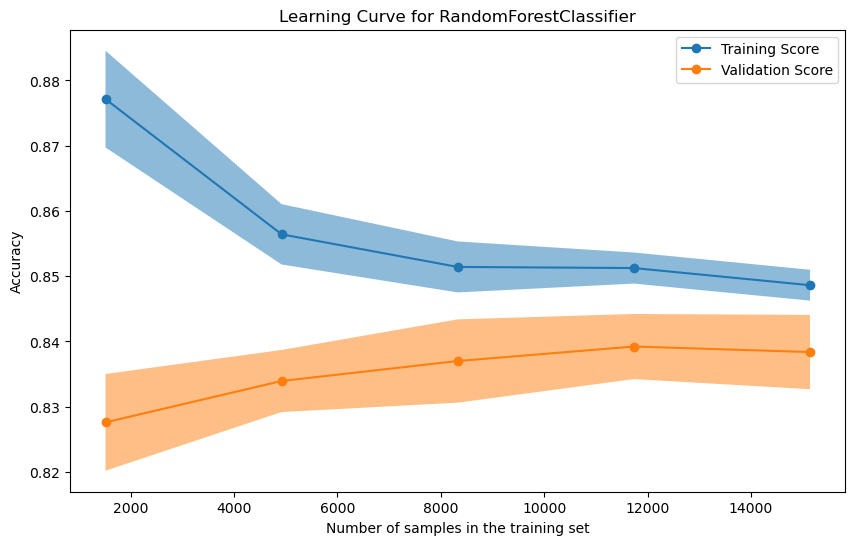

In [992]:
from sklearn.model_selection import LearningCurveDisplay

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

estimator = RandomForestClassifier(**best_params)

common_params = {
    "X": X_train,
    "y": train_df['Label'],
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": 5,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Validation Score"])
ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")

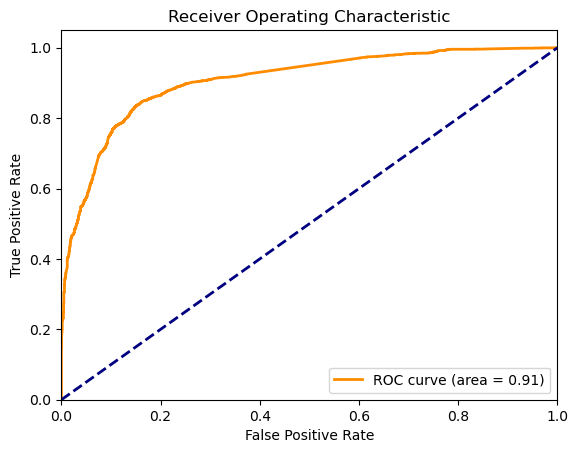

In [993]:
predictions_probability = rf_classifier.predict_proba(X_test)[:, 1]  
fpr, tpr, thresholds = roc_curve(test_df['Label'], predictions_probability)
roc_auc = auc(fpr, tpr) 

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 1.1.2. KNN for Count Vectorisation - N Grams

In [602]:
start_time = time.time()
params = {'n_neighbors': [9],      
          'weights': ['uniform'], 
          'algorithm': ['ball_tree'], 
          'metric': ['euclidean'],  
          'p': [1, 2],
         }
grid_knn = GridSearchCV(KNeighborsClassifier(), cv=5, param_grid=params)
grid_knn.fit(X_train, train_df['Label'])
grid_knn.best_params_
run_time = time.time() - start_time
print('Running time: %s' % datetime.timedelta(seconds = run_time))

Running time: 0:07:15.410140


In [603]:
knn_classifier = grid_knn.best_estimator_
best_params  = grid_knn.best_params_
train_pred_knn = knn_classifier.predict(X_train)
test_pred_knn = knn_classifier.predict(X_test)

train_accuracy = accuracy_score(train_df['Label'], train_pred_knn)
test_accuracy = accuracy_score(test_df['Label'], test_pred_knn)

classification_rep = classification_report(test_df['Label'], test_pred_knn)

print("\nKNN best params:", best_params)

print("\nKNN Training Accuracy:", np.round(train_accuracy * 100, 2), "%")

print("\nKNN CV Accuracy:", np.round(np.median(grid_knn.best_score_) * 100, 2), "%")
print("\nKNN Test Accuracy:", np.round(test_accuracy * 100, 2), "%")

print("\nKNN Classification Report:")
print(classification_rep)


KNN best params: {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}

KNN Training Accuracy: 80.82 %

KNN CV Accuracy: 76.58 %

KNN Test Accuracy: 77.13 %

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.89      0.80      2451
           1       0.85      0.64      0.73      2281

    accuracy                           0.77      4732
   macro avg       0.79      0.77      0.77      4732
weighted avg       0.78      0.77      0.77      4732



Text(0.5, 1.0, 'Learning Curve for KNeighborsClassifier')

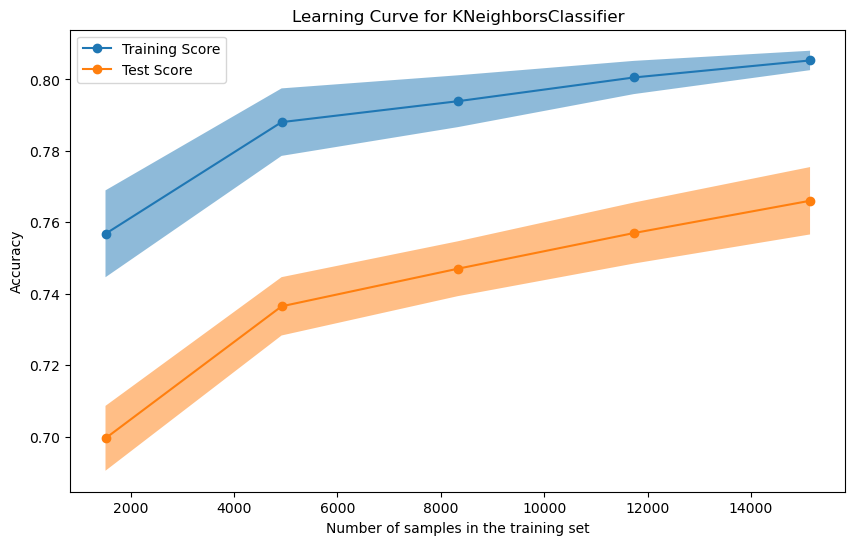

In [604]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

estimator = KNeighborsClassifier(**best_params)

common_params = {
    "X": X_train,
    "y": train_df['Label'],
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": 5,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")

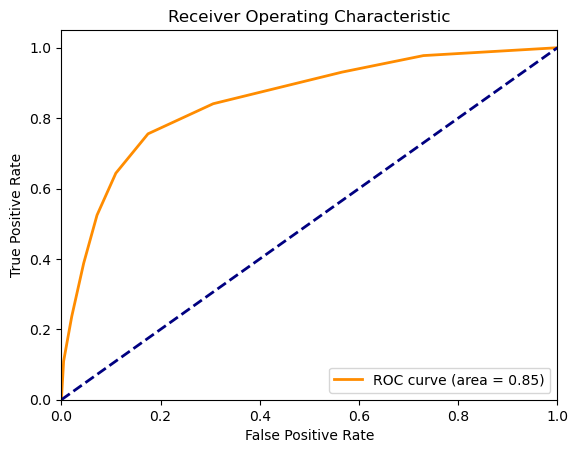

In [606]:
predictions_probability = knn_classifier.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(test_df['Label'], predictions_probability)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 1.1.3. SVM for Count Vectorisation - N Grams

In [819]:
start_time = time.time()

params = {
    'C': [10],              
    'kernel': ['linear'], 
    'degree':[2],
    'gamma': ['scale', 'auto'], 
    'probability': [True],    
}
grid_svm = GridSearchCV(SVC(random_state=42), cv=5, param_grid=params)
grid_svm.fit(X_train, train_df['Label'])
grid_svm.best_params_
run_time = time.time() - start_time
print('Running time: %s' % datetime.timedelta(seconds = run_time))

Running time: 2:28:32.664750


In [820]:
svm_classifier = grid_svm.best_estimator_
best_params  = grid_svm.best_params_
train_pred_svm = svm_classifier.predict(X_train)
test_pred_svm = svm_classifier.predict(X_test)

train_accuracy = accuracy_score(train_df['Label'], train_pred_svm)
test_accuracy = accuracy_score(test_df['Label'], test_pred_svm)

classification_rep = classification_report(test_df['Label'], test_pred_svm)

print("\nSVM best params:", best_params)

print("\nSVM Training Accuracy:", np.round(train_accuracy * 100, 2), "%")

print("\nSVM CV Accuracy:", np.round(np.median(grid_svm.best_score_) * 100, 2), "%")
print("\nSVM Test Accuracy:", np.round(test_accuracy * 100, 2), "%")

print("\nSVM Classification Report:")
print(classification_rep)


SVM best params: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'probability': True}

SVM Training Accuracy: 84.99 %

SVM CV Accuracy: 84.56 %

SVM Test Accuracy: 84.7 %

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      2451
           1       0.86      0.82      0.84      2281

    accuracy                           0.85      4732
   macro avg       0.85      0.85      0.85      4732
weighted avg       0.85      0.85      0.85      4732



Text(0.5, 1.0, 'Learning Curve for SVC')

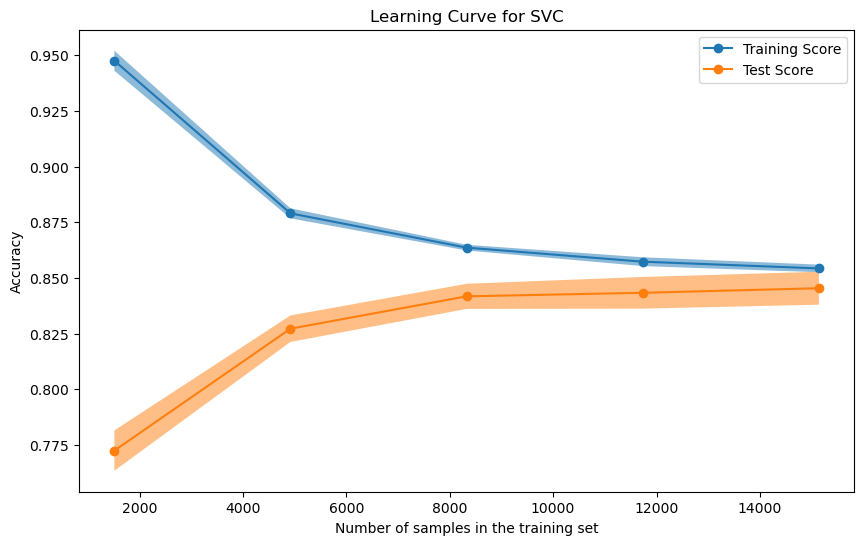

In [821]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

estimator = SVC(**best_params)

common_params = {
    "X": X_train,
    "y": train_df['Label'],
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": 5,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")

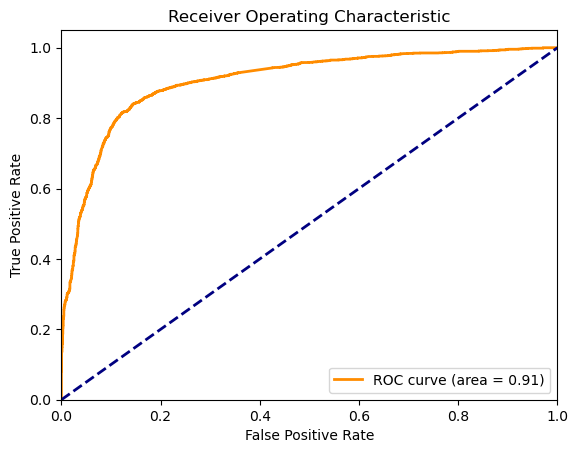

In [823]:
predictions_probability = svm_classifier.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(test_df['Label'], predictions_probability)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 1.1.4. Logistic Regression for Count Vectorisation - N-Grams

In [861]:
start_time = time.time()
params = {
    'penalty': ['l2'],  
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'max_iter': [2000, 3000]
}
grid_lr = GridSearchCV(LogisticRegression(random_state=42), cv=5, param_grid=params)
grid_lr.fit(X_train, train_df['Label'])
grid_lr.best_params_
run_time = time.time() - start_time
print('Running time: %s' % datetime.timedelta(seconds = run_time))

/Users/sandy/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandy/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandy/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandy/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandy/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Running time: 0:53:30.839858


In [862]:
lr_classifier = grid_lr.best_estimator_
best_params  = grid_lr.best_params_
train_pred_lr = lr_classifier.predict(X_train)
test_pred_lr = lr_classifier.predict(X_test)

train_accuracy = accuracy_score(train_df['Label'], train_pred_lr)
test_accuracy = accuracy_score(test_df['Label'], test_pred_lr)

classification_rep = classification_report(test_df['Label'], test_pred_lr)

print("\nLogistic Regression best params:", best_params)

print("\Logistic Regression Training Accuracy:", np.round(train_accuracy * 100, 2), "%")

#print("\nLogistic Regression CV Accuracy:", np.round(np.median(grid_lr.best_score_) * 100, 2), "%")
print("\nLogistic Regression CV Accuracy:", grid_lr.best_score_)
print("\nLogistic Regression Test Accuracy:", np.round(test_accuracy * 100, 2), "%")

print("\nLogistic Regression Classification Report:")
print(classification_rep)


Logistic Regression best params: {'C': 1, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'saga'}
\Logistic Regression Training Accuracy: 85.74 %

Logistic Regression CV Accuracy: 0.844454860813077

Logistic Regression Test Accuracy: 84.0 %

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      2451
           1       0.85      0.81      0.83      2281

    accuracy                           0.84      4732
   macro avg       0.84      0.84      0.84      4732
weighted avg       0.84      0.84      0.84      4732



Text(0.5, 1.0, 'Learning Curve for LogisticRegression')

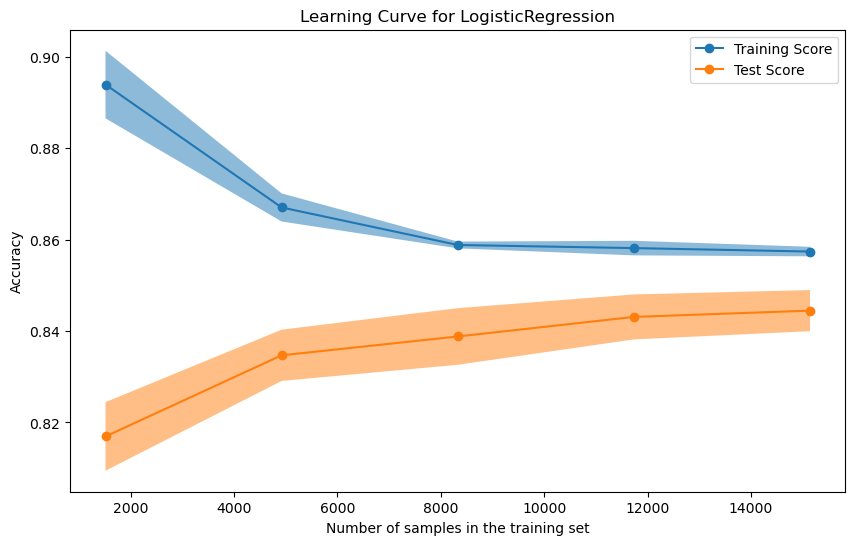

In [863]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

estimator = LogisticRegression(**best_params)

common_params = {
    "X": X_train,
    "y": train_df['Label'],
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": 5,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")

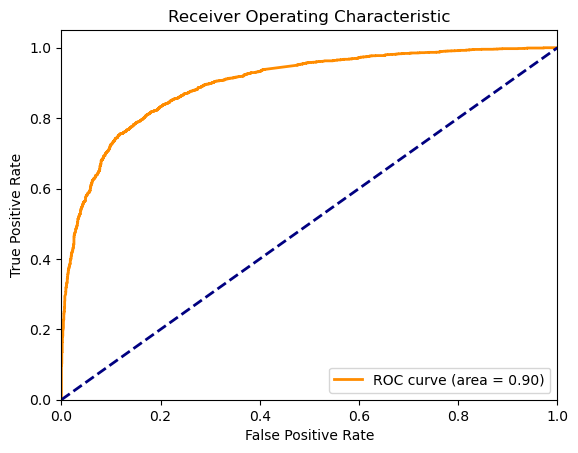

In [864]:
predictions_probability = lr_classifier.predict_proba(X_test_tfidf)[:, 1] 
fpr, tpr, thresholds = roc_curve(test_df['Label'], predictions_probability)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 2. TF IDF - with Ngrams

In [879]:
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 500
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=max_features)

X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['sentence']).toarray()

X_test_tfidf = tfidf_vectorizer.transform(test_df['sentence']).toarray()

y_train = train_df['Label']
y_test = test_df['Label']

## Random Forest with TF IDF N Grams

In [446]:
start_time = time.time()
params = {'n_estimators': [50,100],
          'max_depth': [10, 15, 20],
          'min_samples_split': [5, 10],
          'min_samples_leaf': [2, 5],
          'bootstrap': [True, False]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), cv=5, param_grid=params)
grid_rf.fit(X_train_tfidf, train_df['Label'])
grid_rf.best_params_
run_time = time.time() - start_time
print('Running time: %s' % datetime.timedelta(seconds = run_time))

Running time: 0:21:12.543508


In [447]:
rf_classifier = grid_rf.best_estimator_
best_params  = grid_rf.best_params_
train_pred_rf = rf_classifier.predict(X_train_tfidf)
test_pred_rf = rf_classifier.predict(X_test_tfidf)

train_accuracy = accuracy_score(train_df['Label'], train_pred_rf)
test_accuracy = accuracy_score(test_df['Label'], test_pred_rf)

classification_rep = classification_report(test_df['Label'], test_pred_rf)

print("\nRF best params:", best_params)

print("\nRF Training Accuracy:", np.round(train_accuracy * 100, 2), "%")

print("\nRF CV Accuracy:", np.round(np.median(grid_rf.best_score_) * 100, 2), "%")
print("\nRF Test Accuracy:", np.round(test_accuracy * 100, 2), "%")

print("\nRF Classification Report:")
print(classification_rep)


RF best params: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}

RF Training Accuracy: 85.21 %

RF CV Accuracy: 0.8395941384548928

RF Test Accuracy: 83.71 %

RF Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      2451
           1       0.87      0.78      0.82      2281

    accuracy                           0.84      4732
   macro avg       0.84      0.84      0.84      4732
weighted avg       0.84      0.84      0.84      4732



Text(0.5, 1.0, 'Learning Curve for RandomForestClassifier')

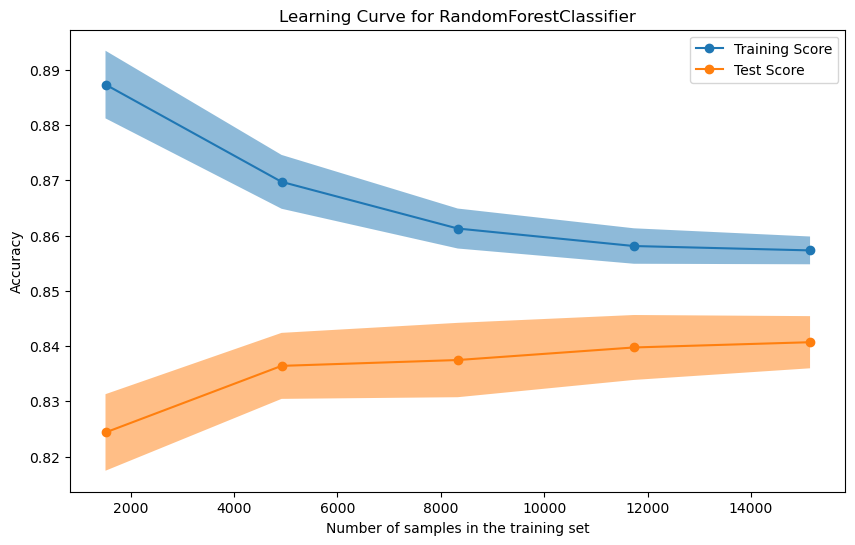

In [448]:
from sklearn.model_selection import LearningCurveDisplay

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

estimator = RandomForestClassifier(**best_params)

common_params = {
    "X": X_train_tfidf,
    "y": train_df['Label'],
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": 5,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")

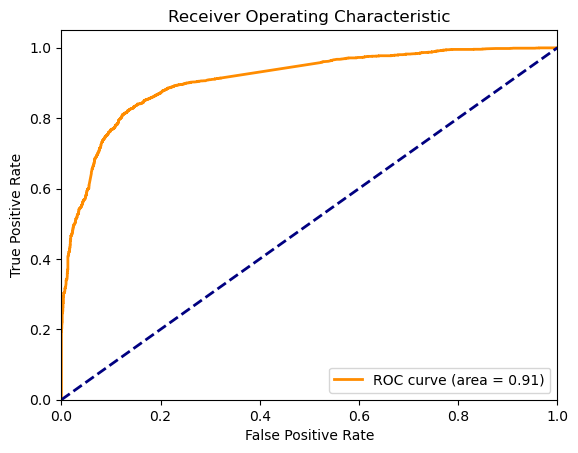

In [450]:
predictions_probability = rf_classifier.predict_proba(X_test_tfidf)[:, 1]  
fpr, tpr, thresholds = roc_curve(test_df['Label'], predictions_probability)
roc_auc = auc(fpr, tpr) 

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## KNN for TF IDF - N Grams

In [900]:
start_time = time.time()

params = {'n_neighbors': [8], 
          'weights': ['uniform'],  
          'algorithm': ['kd_tree', 'auto'],  
          'metric': ['manhattan', 'euclidean'], 
          'p': [1, 2],
         }

grid_knn = GridSearchCV(KNeighborsClassifier(), cv=5, param_grid=params)
grid_knn.fit(X_train_tfidf, train_df['Label'])
grid_knn.best_params_
run_time = time.time() - start_time
print('Running time: %s' % datetime.timedelta(seconds = run_time))

Running time: 0:17:37.126402


In [901]:
knn_classifier = grid_knn.best_estimator_
best_params  = grid_knn.best_params_
train_pred_knn = knn_classifier.predict(X_train_tfidf)
test_pred_knn = knn_classifier.predict(X_test_tfidf)

train_accuracy = accuracy_score(train_df['Label'], train_pred_knn)
test_accuracy = accuracy_score(test_df['Label'], test_pred_knn)

classification_rep = classification_report(test_df['Label'], test_pred_knn)

print("\nKNN best params:", best_params)

print("\nKNN Training Accuracy:", np.round(train_accuracy * 100, 2), "%")

print("\nKNN CV Accuracy:", np.round(np.median(grid_knn.best_score_) * 100, 2), "%")
print("\nKNN Test Accuracy:", np.round(test_accuracy * 100, 2), "%")

print("\nKNN Classification Report:")
print(classification_rep)


KNN best params: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}

KNN Training Accuracy: 71.09 %

KNN CV Accuracy: 64.91 %

KNN Test Accuracy: 65.93 %

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.90      0.73      2451
           1       0.79      0.40      0.53      2281

    accuracy                           0.66      4732
   macro avg       0.70      0.65      0.63      4732
weighted avg       0.70      0.66      0.64      4732



Text(0.5, 1.0, 'Learning Curve for KNeighborsClassifier')

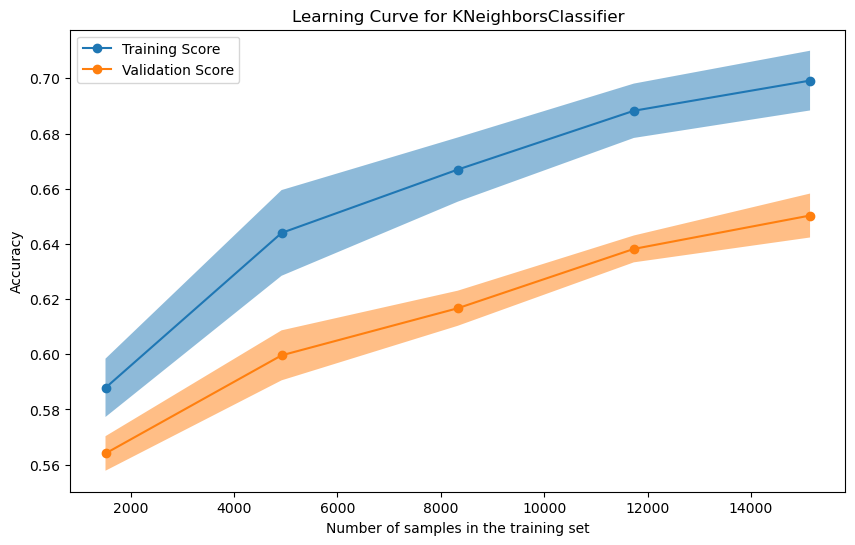

In [902]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

estimator = KNeighborsClassifier(**best_params)

common_params = {
    "X": X_train_tfidf,
    "y": train_df['Label'],
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": 5,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Validation Score"])
ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")

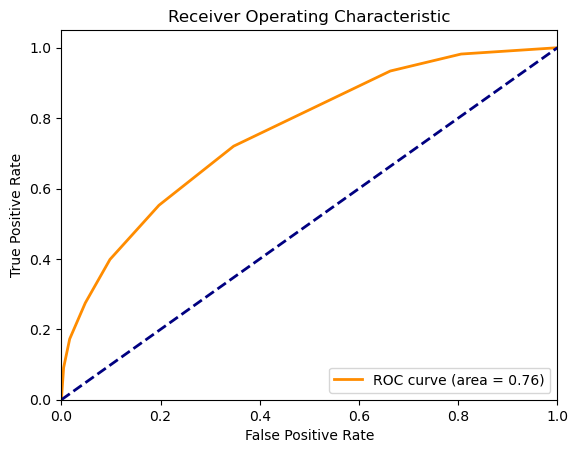

In [903]:
predictions_probability = knn_classifier.predict_proba(X_test_tfidf)[:, 1] 
fpr, tpr, thresholds = roc_curve(test_df['Label'], predictions_probability)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## SVM for TF IDF - N Grams

In [871]:
start_time = time.time()

params = {
    'C': [10],               
    'kernel': ['linear'],  
    'gamma': ['scale', 'auto'],  
    'probability': [True],         
}

grid_svm = GridSearchCV(SVC(random_state=42), cv=5, param_grid=params)
grid_svm.fit(X_train_tfidf, train_df['Label'])
grid_svm.best_params_
run_time = time.time() - start_time
print('Running time: %s' % datetime.timedelta(seconds = run_time))

Running time: 1:12:32.432350


In [872]:
svm_classifier = grid_svm.best_estimator_
best_params  = grid_svm.best_params_
train_pred_svm = svm_classifier.predict(X_train_tfidf)
test_pred_svm = svm_classifier.predict(X_test_tfidf)

train_accuracy = accuracy_score(train_df['Label'], train_pred_svm)
test_accuracy = accuracy_score(test_df['Label'], test_pred_svm)

classification_rep = classification_report(test_df['Label'], test_pred_svm)

print("\nSVM best params:", best_params)

print("\nSVM Training Accuracy:", np.round(train_accuracy * 100, 2), "%")

print("\nSVM CV Accuracy:", np.round(np.median(grid_svm.best_score_) * 100, 2), "%")
print("\nSVM Test Accuracy:", np.round(test_accuracy * 100, 2), "%")

print("\nSVM Classification Report:")
print(classification_rep)


SVM best params: {'C': 10, 'gamma': 'scale', 'kernel': 'linear', 'probability': True}

SVM Training Accuracy: 86.14 %

SVM CV Accuracy: 84.94 %

SVM Test Accuracy: 85.08 %

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      2451
           1       0.85      0.83      0.84      2281

    accuracy                           0.85      4732
   macro avg       0.85      0.85      0.85      4732
weighted avg       0.85      0.85      0.85      4732



Text(0.5, 1.0, 'Learning Curve for SVC')

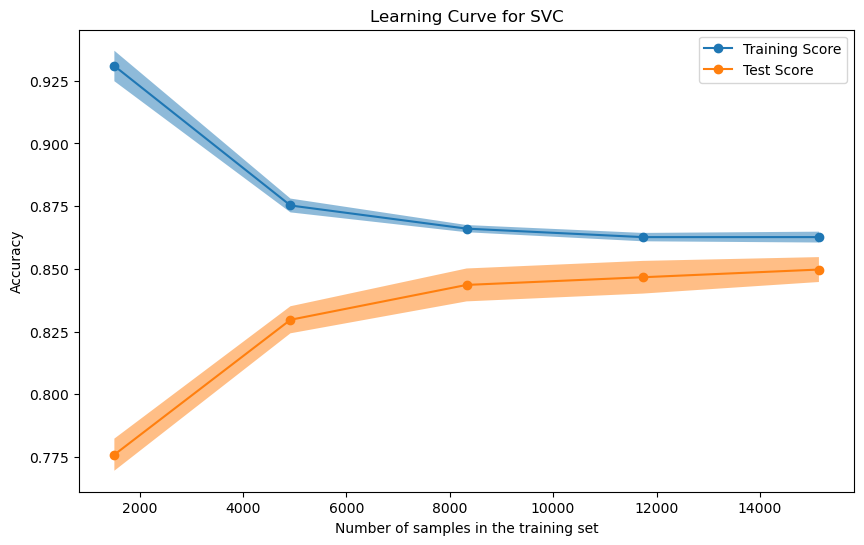

In [873]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

estimator = SVC(**best_params)

common_params = {
    "X": X_train_tfidf,
    "y": train_df['Label'],
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": 5,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")

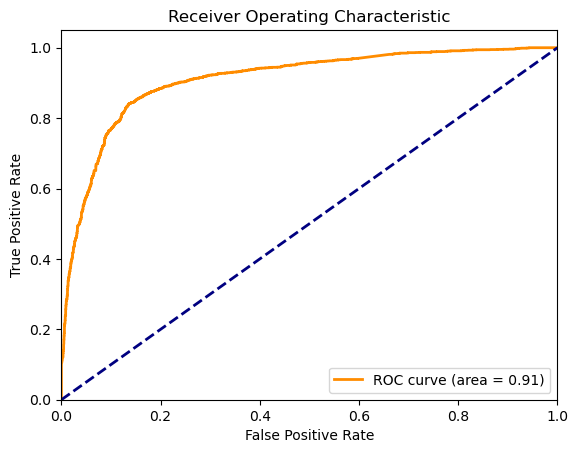

In [874]:
predictions_probability = svm_classifier.predict_proba(X_test_tfidf)[:, 1] 
fpr, tpr, thresholds = roc_curve(test_df['Label'], predictions_probability)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Logistic Regression for TF IDF - N Grams

In [875]:
start_time = time.time()

params = {
    'penalty': ['l2'], 
    'C': [1, 10],
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'max_iter': [1000, 2000, 3000]
}
grid_lr = GridSearchCV(LogisticRegression(random_state=42), cv=5, param_grid=params)
grid_lr.fit(X_train_tfidf, train_df['Label'])
grid_lr.best_params_
run_time = time.time() - start_time
print('Running time: %s' % datetime.timedelta(seconds = run_time))

Running time: 0:02:05.368673


In [876]:
lr_classifier = grid_lr.best_estimator_
best_params  = grid_lr.best_params_
train_pred_lr = lr_classifier.predict(X_train_tfidf)
test_pred_lr = lr_classifier.predict(X_test_tfidf)

train_accuracy = accuracy_score(train_df['Label'], train_pred_lr)
test_accuracy = accuracy_score(test_df['Label'], test_pred_lr)

classification_rep = classification_report(test_df['Label'], test_pred_lr)

print("\nLogistic Regression best params:", best_params)

print("\Logistic Regression Training Accuracy:", np.round(train_accuracy * 100, 2), "%")

print("\nLogistic Regression CV Accuracy:", np.round(np.median(grid_lr.best_score_) * 100, 2), "%")

print("\nLogistic Regression Test Accuracy:", np.round(test_accuracy * 100, 2), "%")

print("\nLogistic Regression Classification Report:")
print(classification_rep)


Logistic Regression best params: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
\Logistic Regression Training Accuracy: 85.66 %

Logistic Regression CV Accuracy: 84.63 %

Logistic Regression Test Accuracy: 84.11 %

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      2451
           1       0.85      0.82      0.83      2281

    accuracy                           0.84      4732
   macro avg       0.84      0.84      0.84      4732
weighted avg       0.84      0.84      0.84      4732



Text(0.5, 1.0, 'Learning Curve for LogisticRegression')

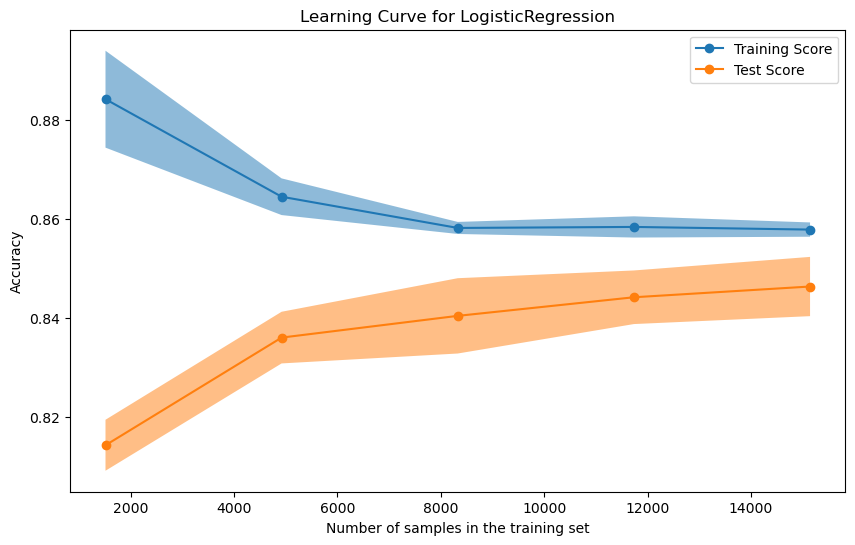

In [877]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

estimator = LogisticRegression(**best_params)

common_params = {
    "X": X_train_tfidf,
    "y": train_df['Label'],
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": 5,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")

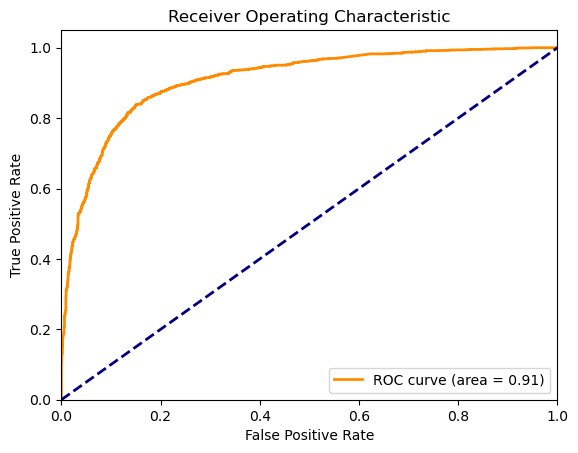

In [878]:
predictions_probability = lr_classifier.predict_proba(X_test_tfidf)[:, 1] 
fpr, tpr, thresholds = roc_curve(test_df['Label'], predictions_probability)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 2. Classifiers for CBOW

## 2.1 Train CBOW Embedding

In [749]:
all_tokens = combined_df['filtered_text']

model_cbow = Word2Vec(vector_size=50, window=5, min_count=1, workers=4, sg=0)
model_cbow.build_vocab(all_tokens)
model_cbow.train(all_tokens, total_examples=len(all_tokens), epochs=10)

(2831630, 3046070)

In [750]:
def get_average_word_embedding(text, model):
    embeddings = []
    for word in text:
        if word in model.wv.key_to_index:
            embeddings.append(model.wv[word])
    if not embeddings:
        return np.zeros(model.vector_size)
    return np.mean(embeddings, axis=0)

In [751]:
X_train_cbow = np.array([get_average_word_embedding(tokens, model_cbow) for tokens in train_df['filtered_text']])
X_test_cbow = np.array([get_average_word_embedding(tokens, model_cbow) for tokens in test_df['filtered_text']])

## 2.2 Train Random Forest Classifier on CBOW embeddings

In [682]:
start_time = time.time()
params = {'n_estimators': [50,100],
          'max_depth': [8],
          'min_samples_split': [5],
          'min_samples_leaf': [2],
          'bootstrap': [True, False]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), cv=5, param_grid=params)
grid_rf.fit(X_train_cbow, train_df['Label'])
grid_rf.best_params_
run_time = time.time() - start_time
print('Running time: %s' % datetime.timedelta(seconds = run_time))

Running time: 0:03:41.487382


In [683]:
rf_classifier = grid_rf.best_estimator_
best_params  = grid_rf.best_params_
train_pred_rf = rf_classifier.predict(X_train_cbow)
test_pred_rf = rf_classifier.predict(X_test_cbow)

train_accuracy = accuracy_score(train_df['Label'], train_pred_rf)
test_accuracy = accuracy_score(test_df['Label'], test_pred_rf)

classification_rep = classification_report(test_df['Label'], test_pred_rf)

print("\nRF best params:", best_params)

print("\nRF Training Accuracy:", np.round(train_accuracy * 100, 2), "%")

print("\nRF CV Accuracy:", np.round(np.median(grid_rf.best_score_) * 100, 2), "%")
print("\nRF Test Accuracy:", np.round(test_accuracy * 100, 2), "%")

print("\nRF Classification Report:")
print(classification_rep)


RF best params: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

RF Training Accuracy: 87.82 %

RF CV Accuracy: 77.23 %

RF Test Accuracy: 77.77 %

RF Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78      2451
           1       0.75      0.81      0.78      2281

    accuracy                           0.78      4732
   macro avg       0.78      0.78      0.78      4732
weighted avg       0.78      0.78      0.78      4732



Text(0.5, 1.0, 'Learning Curve for RandomForestClassifier')

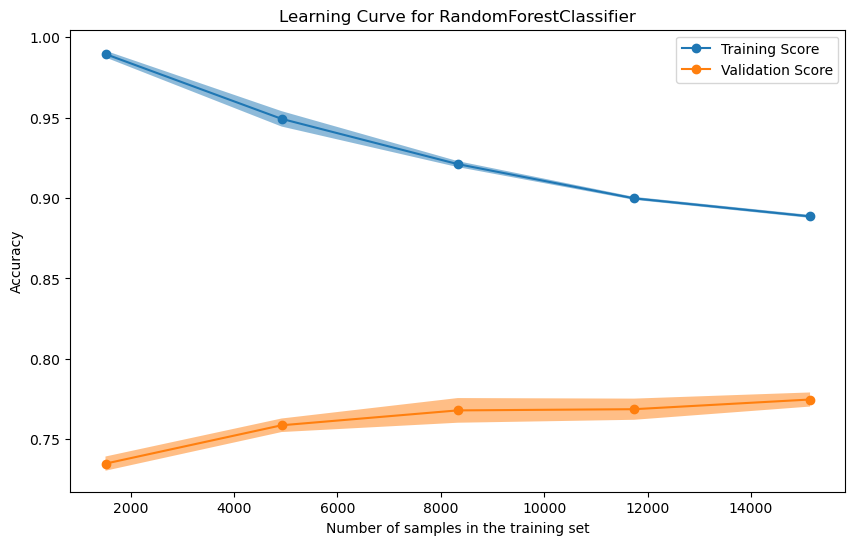

In [684]:
from sklearn.model_selection import LearningCurveDisplay

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

estimator = RandomForestClassifier(**best_params)

common_params = {
    "X": X_train_cbow,
    "y": train_df['Label'],
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": 5,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Validation Score"])
ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")

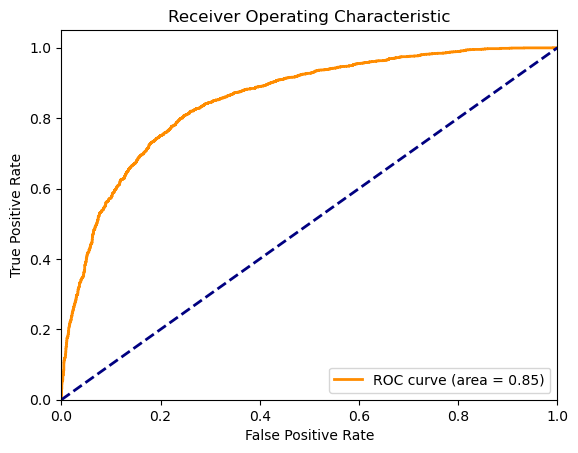

In [686]:
predictions_probability = rf_classifier.predict_proba(X_test_cbow)[:, 1]  
fpr, tpr, thresholds = roc_curve(test_df['Label'], predictions_probability)
roc_auc = auc(fpr, tpr) 

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 2.3 Train KNN Classifier on CBOW embeddings

In [626]:
start_time = time.time()
params = {'n_neighbors': [8],      
          'weights': ['uniform'], 
          'algorithm': ['ball_tree', 'kd_tree'],  
          'metric': ['euclidean'], 
          'p': [1, 2], 
         }
grid_knn = GridSearchCV(KNeighborsClassifier(), cv=5, param_grid=params)
grid_knn.fit(X_train_cbow, train_df['Label'])
grid_knn.best_params_
run_time = time.time() - start_time
print('Running time: %s' % datetime.timedelta(seconds = run_time))

Running time: 0:02:25.095906


In [627]:
knn_classifier = grid_knn.best_estimator_
best_params  = grid_knn.best_params_
train_pred_knn = knn_classifier.predict(X_train_cbow)
test_pred_knn = knn_classifier.predict(X_test_cbow)

train_accuracy = accuracy_score(train_df['Label'], train_pred_knn)
test_accuracy = accuracy_score(test_df['Label'], test_pred_knn)

classification_rep = classification_report(test_df['Label'], test_pred_knn)

print("\nKNN best params:", best_params)

print("\nKNN Training Accuracy:", np.round(train_accuracy * 100, 2), "%")

print("\nKNN CV Accuracy:", np.round(np.median(grid_knn.best_score_) * 100, 2), "%")
print("\nKNN Test Accuracy:", np.round(test_accuracy * 100, 2), "%")

print("\nKNN Classification Report:")
print(classification_rep)


KNN best params: {'algorithm': 'kd_tree', 'metric': 'euclidean', 'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}

KNN Training Accuracy: 80.12 %

KNN CV Accuracy: 74.43 %

KNN Test Accuracy: 73.69 %

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.74      0.75      2451
           1       0.73      0.73      0.73      2281

    accuracy                           0.74      4732
   macro avg       0.74      0.74      0.74      4732
weighted avg       0.74      0.74      0.74      4732



Text(0.5, 1.0, 'Learning Curve for KNeighborsClassifier')

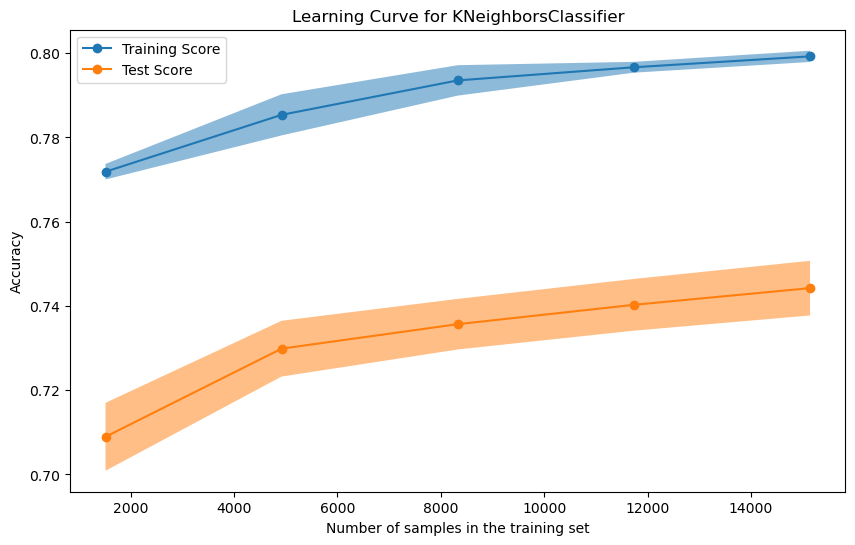

In [628]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

estimator = KNeighborsClassifier(**best_params)

common_params = {
    "X": X_train_cbow,
    "y": train_df['Label'],
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": 5,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")

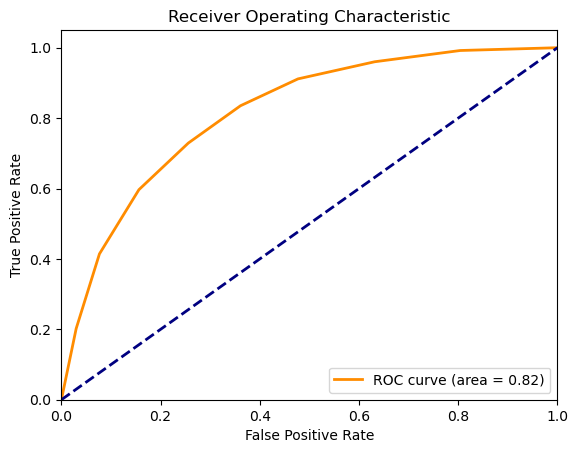

In [630]:
predictions_probability = knn_classifier.predict_proba(X_test_cbow)[:, 1] 
fpr, tpr, thresholds = roc_curve(test_df['Label'], predictions_probability)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Train SVM Classifier on CBOW embeddings

In [687]:
start_time = time.time()

params = {
    'C': [10],          
    'kernel': ['poly', 'rbf'],
    'degree': [2],          
    'gamma': ['scale', 'auto'],   
    'probability': [True],          
}
grid_svm = GridSearchCV(SVC(random_state=42, probability=True), cv=5, param_grid=params)
grid_svm.fit(X_train_cbow, train_df['Label'])
grid_svm.best_params_
run_time = time.time() - start_time
print('Running time: %s' % datetime.timedelta(seconds = run_time))

Running time: 0:56:54.827322


In [688]:
svm_classifier = grid_svm.best_estimator_
best_params  = grid_svm.best_params_
train_pred_svm = svm_classifier.predict(X_train_cbow)
test_pred_svm = svm_classifier.predict(X_test_cbow)

train_accuracy = accuracy_score(train_df['Label'], train_pred_svm)
test_accuracy = accuracy_score(test_df['Label'], test_pred_svm)

classification_rep = classification_report(test_df['Label'], test_pred_svm)

print("\nSVM best params:", best_params)

print("\nSVM Training Accuracy:", np.round(train_accuracy * 100, 2), "%")

print("\nSVM CV Accuracy:", np.round(np.median(grid_svm.best_score_) * 100, 2), "%")
print("\nSVM Test Accuracy:", np.round(test_accuracy * 100, 2), "%")

print("\nSVM Classification Report:")
print(classification_rep)


SVM best params: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}

SVM Training Accuracy: 81.7 %

SVM CV Accuracy: 79.49 %

SVM Test Accuracy: 79.82 %

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80      2451
           1       0.79      0.79      0.79      2281

    accuracy                           0.80      4732
   macro avg       0.80      0.80      0.80      4732
weighted avg       0.80      0.80      0.80      4732



Text(0.5, 1.0, 'Learning Curve for SVC')

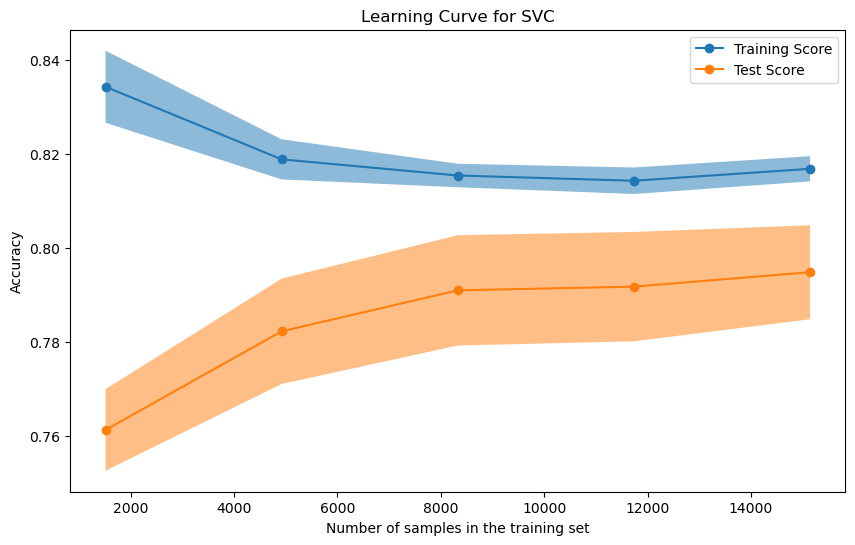

In [689]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

estimator = SVC(**best_params)

common_params = {
    "X": X_train_cbow,
    "y": train_df['Label'],
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": 5,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")

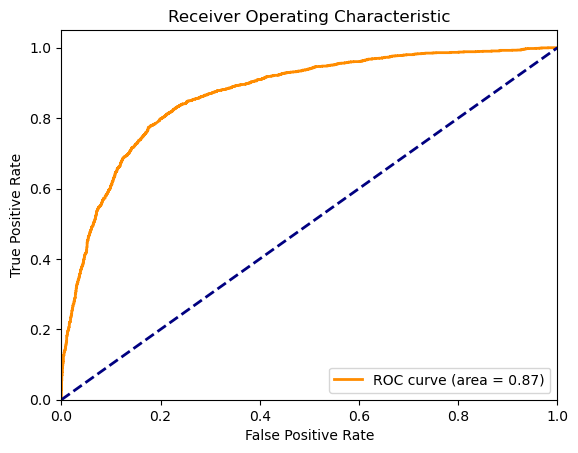

In [691]:
predictions_probability = svm_classifier.predict_proba(X_test_cbow)[:, 1] 
fpr, tpr, thresholds = roc_curve(test_df['Label'], predictions_probability)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 2.5. Train Logistic Regression on CBOW embeddings

In [752]:
start_time = time.time()

params = {
    'penalty': ['l2'], 
    'C': [1, 10],
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'max_iter': [1000, 2000, 3000]
}
grid_lr = GridSearchCV(LogisticRegression(random_state=42), cv=5, param_grid=params)
grid_lr.fit(X_train_cbow, train_df['Label'])
grid_lr.best_params_
run_time = time.time() - start_time
print('Running time: %s' % datetime.timedelta(seconds = run_time))

Running time: 0:02:32.155645


In [753]:
lr_classifier = grid_lr.best_estimator_
best_params  = grid_lr.best_params_
train_pred_lr = lr_classifier.predict(X_train_cbow)
test_pred_lr = lr_classifier.predict(X_test_cbow)

train_accuracy = accuracy_score(train_df['Label'], train_pred_lr)
test_accuracy = accuracy_score(test_df['Label'], test_pred_lr)

classification_rep = classification_report(test_df['Label'], test_pred_lr)

print("\nLogistic Regression best params:", best_params)

print("\Logistic Regression Training Accuracy:", np.round(train_accuracy * 100, 2), "%")

print("\nLogistic Regression CV Accuracy:", np.round(np.median(grid_lr.best_score_) * 100, 2), "%")
print("\nLogistic Regression Test Accuracy:", np.round(test_accuracy * 100, 2), "%")

print("\nLogistic Regression Classification Report:")
print(classification_rep)


Logistic Regression best params: {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
\Logistic Regression Training Accuracy: 75.43 %

Logistic Regression CV Accuracy: 75.24 %

Logistic Regression Test Accuracy: 75.32 %

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.76      2451
           1       0.75      0.74      0.74      2281

    accuracy                           0.75      4732
   macro avg       0.75      0.75      0.75      4732
weighted avg       0.75      0.75      0.75      4732



Text(0.5, 1.0, 'Learning Curve for LogisticRegression')

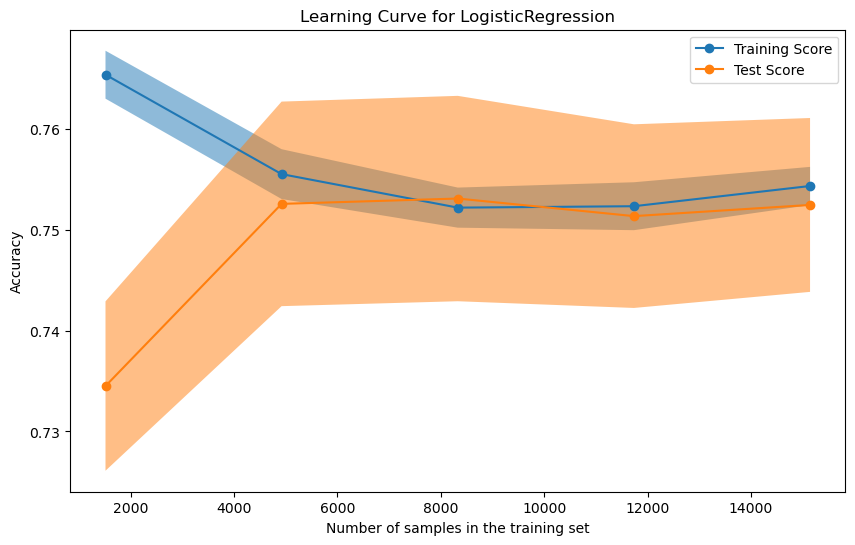

In [754]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

estimator = LogisticRegression(**best_params)

common_params = {
    "X": X_train_cbow,
    "y": train_df['Label'],
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": 5,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")

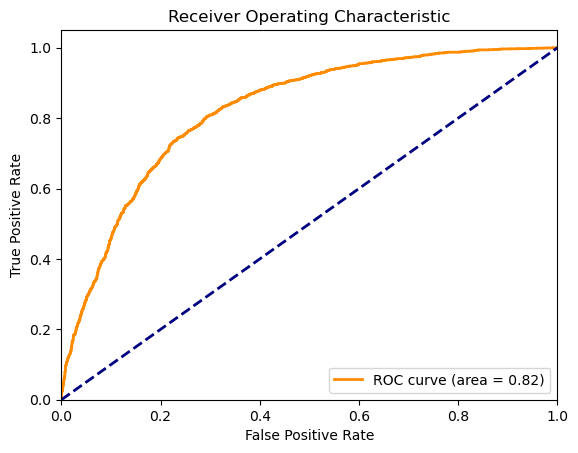

In [756]:
predictions_probability = lr_classifier.predict_proba(X_test_cbow)[:, 1] 
fpr, tpr, thresholds = roc_curve(test_df['Label'], predictions_probability)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 3. Classifiers for SkipGram

## 3.1 Train SkipGram  embedding 

In [757]:
all_tokens = combined_df['filtered_text']
 
model_skipgram = Word2Vec(vector_size=50, window=5, min_count=1, workers=4, sg=1)
model_skipgram.build_vocab(all_tokens)
model_skipgram.train(all_tokens, total_examples=len(all_tokens), epochs=10)

(2832039, 3046070)

In [758]:
X_train_skipgram = np.array([get_average_word_embedding(tokens, model_skipgram) for tokens in train_df['filtered_text']])
X_test_skipgram = np.array([get_average_word_embedding(tokens, model_skipgram) for tokens in test_df['filtered_text']])

## 3.2 Train Random Forest Classifier on SkipGram embeddings

In [699]:
start_time = time.time()

params = {'n_estimators': [50,100],
          'max_depth': [7],
          'min_samples_split': [5],
          'min_samples_leaf': [2],
          'bootstrap': [True, False]}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), cv=5, param_grid=params)
grid_rf.fit(X_train_skipgram, train_df['Label'])

run_time = time.time() - start_time
print('Running time: %s' % datetime.timedelta(seconds = run_time))

Running time: 0:02:33.932794


In [700]:
rf_classifier = grid_rf.best_estimator_
best_params  = grid_rf.best_params_
train_pred_rf = rf_classifier.predict(X_train_skipgram)
test_pred_rf = rf_classifier.predict(X_test_skipgram)

train_accuracy = accuracy_score(train_df['Label'], train_pred_rf)
test_accuracy = accuracy_score(test_df['Label'], test_pred_rf)

classification_rep = classification_report(test_df['Label'], test_pred_rf)

print("\nRF best params:", grid_rf.best_params_)

print("\nRF Training Accuracy:", np.round(train_accuracy * 100, 2), "%")

print("\nRF CV Accuracy:", np.round(np.median(grid_rf.best_score_) * 100, 2), "%")
print("\nRF Test Accuracy:", np.round(test_accuracy * 100, 2), "%")

print("\nRF Classification Report:")
print(classification_rep)


RF best params: {'bootstrap': False, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

RF Training Accuracy: 79.9 %

RF CV Accuracy: 75.13 %

RF Test Accuracy: 75.08 %

RF Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.71      0.75      2451
           1       0.72      0.79      0.75      2281

    accuracy                           0.75      4732
   macro avg       0.75      0.75      0.75      4732
weighted avg       0.75      0.75      0.75      4732



Text(0.5, 1.0, 'Learning Curve for RandomForestClassifier')

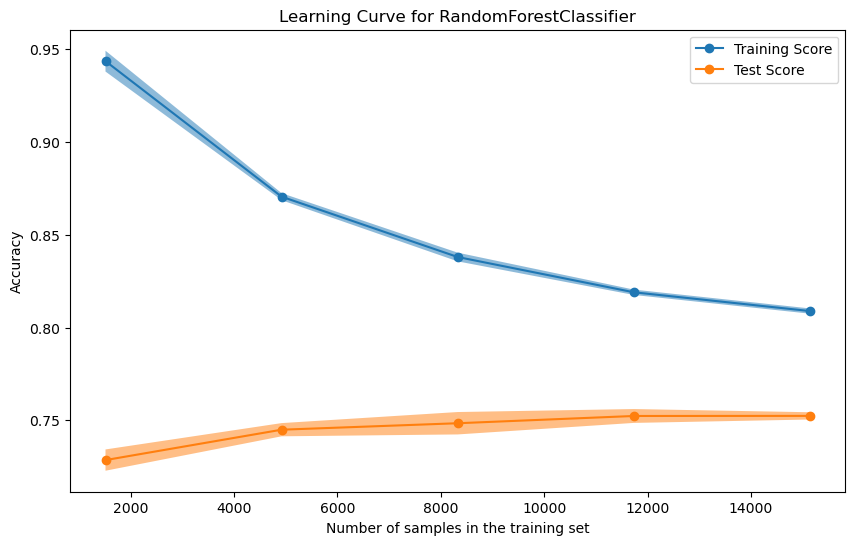

In [701]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

estimator = RandomForestClassifier(**best_params)

common_params = {
    "X": X_train_skipgram,
    "y": train_df['Label'],
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": 5,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")

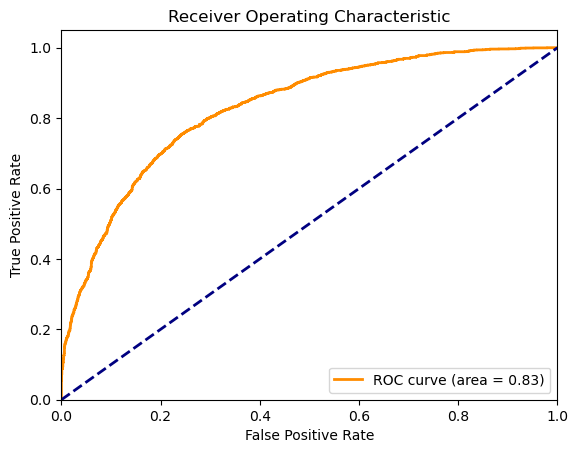

In [703]:
predictions_probability = rf_classifier.predict_proba(X_test_skipgram)[:, 1]  
fpr, tpr, thresholds = roc_curve(test_df['Label'], predictions_probability)
roc_auc = auc(fpr, tpr) 

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# KNN for SkipGram

In [759]:
start_time = time.time()

params = {'n_neighbors': [7],      
          'weights': ['uniform'], 
          'algorithm': ['ball_tree','kd_tree'], 
          'metric': ['manhattan', 'euclidean'],
         }

grid_knn = GridSearchCV(KNeighborsClassifier(), cv=5, param_grid=params)
grid_knn.fit(X_train_skipgram, train_df['Label'])
grid_knn.best_params_
run_time = time.time() - start_time
print('Running time: %s' % datetime.timedelta(seconds = run_time))

Running time: 0:06:11.098152


In [760]:
knn_classifier = grid_knn.best_estimator_
best_params  = grid_knn.best_params_
train_pred_knn = knn_classifier.predict(X_train_skipgram)
test_pred_knn = knn_classifier.predict(X_test_skipgram)

train_accuracy = accuracy_score(train_df['Label'], train_pred_knn)
test_accuracy = accuracy_score(test_df['Label'], test_pred_knn)

classification_rep = classification_report(test_df['Label'], test_pred_knn)

print("\nKNN best params:", best_params)

print("\nKNN Training Accuracy:", np.round(train_accuracy * 100, 2), "%")

print("\nKNN CV Accuracy:", np.round(np.median(grid_knn.best_score_) * 100, 2), "%")
print("\nKNN Test Accuracy:", np.round(test_accuracy * 100, 2), "%")

print("\nKNN Classification Report:")
print(classification_rep)


KNN best params: {'algorithm': 'kd_tree', 'metric': 'euclidean', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}

KNN Training Accuracy: 78.35 %

KNN CV Accuracy: 72.19 %

KNN Test Accuracy: 72.72 %

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.63      0.71      2451
           1       0.68      0.83      0.75      2281

    accuracy                           0.73      4732
   macro avg       0.74      0.73      0.73      4732
weighted avg       0.74      0.73      0.72      4732



Text(0.5, 1.0, 'Learning Curve for KNeighborsClassifier')

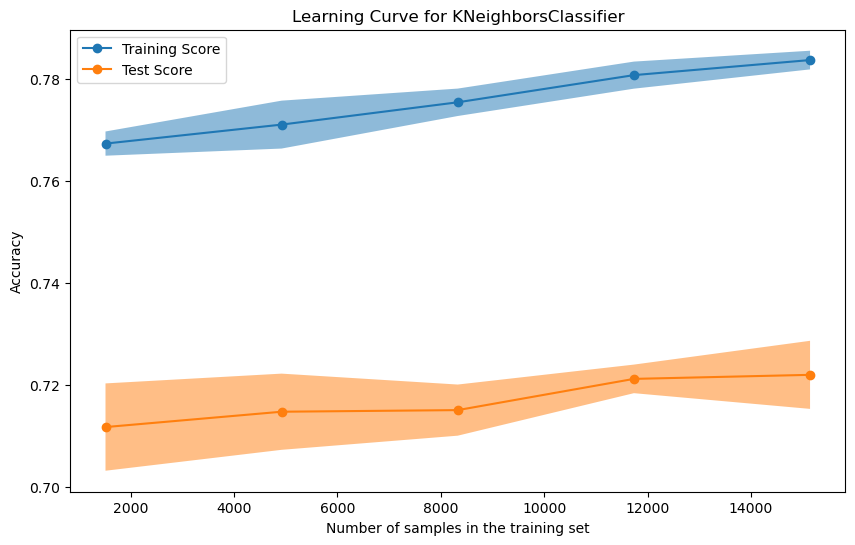

In [761]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

estimator = KNeighborsClassifier(**best_params)

common_params = {
    "X": X_train_skipgram,
    "y": train_df['Label'],
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": 5,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")

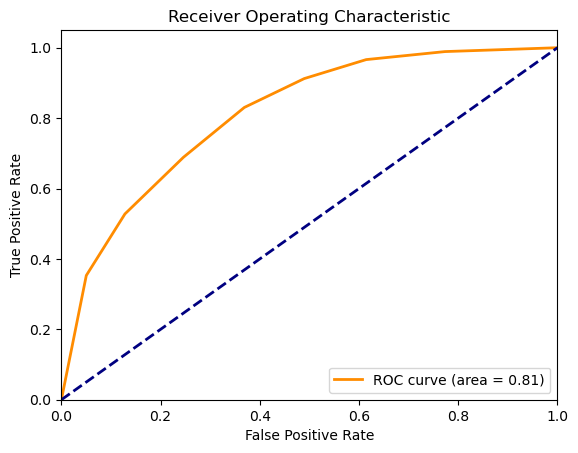

In [763]:
predictions_probability = knn_classifier.predict_proba(X_test_skipgram)[:, 1] 
fpr, tpr, thresholds = roc_curve(test_df['Label'], predictions_probability)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# SVM for SkipGram

In [704]:
start_time = time.time()

params = {'C': [10],              
          'kernel': ['rbf', 'poly'],  
          'degree': [4],     
          'gamma': ['scale', 'auto'],  
          'probability': [True],         
         }

grid_svm = GridSearchCV(SVC(random_state=42), cv=5, param_grid=params)
grid_svm.fit(X_train_skipgram, train_df['Label'])
grid_svm.best_params_
run_time = time.time() - start_time
print('Running time: %s' % datetime.timedelta(seconds = run_time))

Running time: 1:00:46.655922


In [705]:
svm_classifier = grid_svm.best_estimator_
best_params  = grid_svm.best_params_
train_pred_svm = svm_classifier.predict(X_train_skipgram)
test_pred_svm = svm_classifier.predict(X_test_skipgram)

train_accuracy = accuracy_score(train_df['Label'], train_pred_svm)
test_accuracy = accuracy_score(test_df['Label'], test_pred_svm)

classification_rep = classification_report(test_df['Label'], test_pred_svm)

print("\nSVM best params:", best_params)

print("\nSVM Training Accuracy:", np.round(train_accuracy * 100, 2), "%")

print("\nSVM CV Accuracy:", np.round(np.median(grid_svm.best_score_) * 100, 2), "%")
print("\nSVM Test Accuracy:", np.round(test_accuracy * 100, 2), "%")

print("\nSVM Classification Report:")
print(classification_rep)


SVM best params: {'C': 10, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly', 'probability': True}

SVM Training Accuracy: 88.14 %

SVM CV Accuracy: 80.73 %

SVM Test Accuracy: 81.57 %

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      2451
           1       0.81      0.81      0.81      2281

    accuracy                           0.82      4732
   macro avg       0.82      0.82      0.82      4732
weighted avg       0.82      0.82      0.82      4732



Text(0.5, 1.0, 'Learning Curve for SVC')

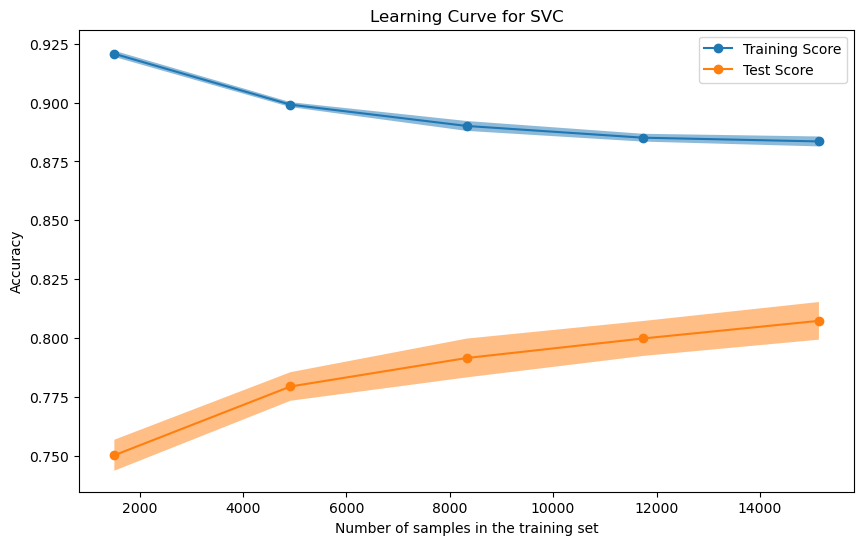

In [706]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

estimator = SVC(**best_params)

common_params = {
    "X": X_train_skipgram,
    "y": train_df['Label'],
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": 5,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")

In [ ]:
predictions_probability = svm_classifier.predict_proba(X_test_skipgram)[:, 1] 
fpr, tpr, thresholds = roc_curve(test_df['Label'], predictions_probability)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Logistic Regression for SkipGram

In [775]:
start_time = time.time()

params = {
    'penalty': ['l2'],
    'C': [1, 10],
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'max_iter': [1000, 2000, 3000]
}

grid_lr = GridSearchCV(LogisticRegression(random_state=42), cv=5, param_grid=params)
grid_lr.fit(X_train_skipgram, train_df['Label'])
grid_lr.best_params_
run_time = time.time() - start_time
print('Running time: %s' % datetime.timedelta(seconds = run_time))

Running time: 0:00:18.620186


In [776]:
lr_classifier = grid_lr.best_estimator_
best_params  = grid_lr.best_params_
train_pred_lr = lr_classifier.predict(X_train_skipgram)
test_pred_lr = lr_classifier.predict(X_test_skipgram)

train_accuracy = accuracy_score(train_df['Label'], train_pred_lr)
test_accuracy = accuracy_score(test_df['Label'], test_pred_lr)

classification_rep = classification_report(test_df['Label'], test_pred_lr)

print("\nLogistic Regression best params:", best_params)

print("\Logistic Regression Training Accuracy:", np.round(train_accuracy * 100, 2), "%")

print("\nLogistic Regression CV Accuracy:", np.round(np.median(grid_lr.best_score_) * 100, 2), "%")
print("\nLogistic Regression Test Accuracy:", np.round(test_accuracy * 100, 2), "%")

print("\nLogistic Regression Classification Report:")
print(classification_rep)


Logistic Regression best params: {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
\Logistic Regression Training Accuracy: 73.49 %

Logistic Regression CV Accuracy: 73.22 %

Logistic Regression Test Accuracy: 73.48 %

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.75      0.75      2451
           1       0.73      0.72      0.72      2281

    accuracy                           0.73      4732
   macro avg       0.73      0.73      0.73      4732
weighted avg       0.73      0.73      0.73      4732



Text(0.5, 1.0, 'Learning Curve for LogisticRegression')

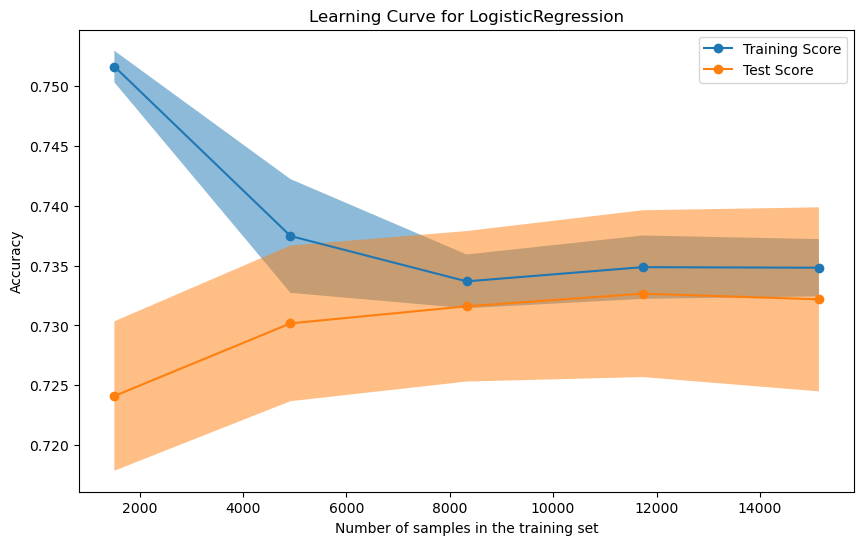

In [777]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

estimator = LogisticRegression(**best_params)

common_params = {
    "X": X_train_skipgram,
    "y": train_df['Label'],
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": 5,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")

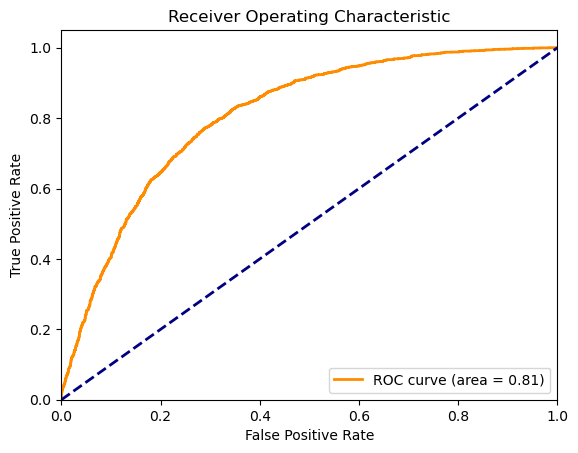

In [779]:
predictions_probability = lr_classifier.predict_proba(X_test_skipgram)[:, 1] 
fpr, tpr, thresholds = roc_curve(test_df['Label'], predictions_probability)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# LSTM

In [919]:
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Flatten, Dense, SpatialDropout1D, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional 
from tensorflow.keras.layers import Embedding, Flatten, Dense, SpatialDropout1D, LSTM, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, Adamax

In [920]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [921]:
max_words = len(model_cbow.wv.index_to_key)
print(f"Vocabulary size : {max_words}")
tokenizer = Tokenizer(num_words=max_words)  
tokenizer.fit_on_texts(train_df['filtered_text'])  

Vocabulary size : 29372


In [922]:
X_train_sequences = tokenizer.texts_to_sequences(train_df['filtered_text'])
X_val_sequences = tokenizer.texts_to_sequences(val_df['filtered_text'])
X_test_sequences = tokenizer.texts_to_sequences(test_df['filtered_text'])

In [923]:
max_sequence_length = 100
print("Maximum sequence length:", max_sequence_length)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)
X_train_padded = X_train_padded.reshape(X_train_padded.shape[0], X_train_padded.shape[1], 1)
X_val_padded = X_val_padded.reshape(X_val_padded.shape[0], X_val_padded.shape[1], 1)
X_test_padded = X_test_padded.reshape(X_test_padded.shape[0], X_test_padded.shape[1], 1)

Maximum sequence length: 100


In [924]:
X_train_padded.shape, train_df['Label'].shape

((9689, 100, 1), (9689,))

In [945]:
model = Sequential()
    
model.add(Embedding(max_words, 64, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate = 0.001), metrics=['accuracy'])

In [946]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [947]:
batch_size = 64
epochs = 100

history = model.fit(
    X_train_padded,
    train_df['Label'],
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_padded, val_df['Label']),
    callbacks=[early_stopping]
)

Epoch 1/100
152/152 [==============================] - 53s 311ms/step - loss: 0.6474 - accuracy: 0.5936 - val_loss: 0.6111 - val_accuracy: 0.6487
Epoch 2/100
152/152 [==============================] - 56s 368ms/step - loss: 0.5141 - accuracy: 0.7592 - val_loss: 0.5292 - val_accuracy: 0.7699
Epoch 3/100
152/152 [==============================] - 49s 323ms/step - loss: 0.3632 - accuracy: 0.8754 - val_loss: 0.5406 - val_accuracy: 0.7786
Epoch 4/100
152/152 [==============================] - 52s 345ms/step - loss: 0.2705 - accuracy: 0.9168 - val_loss: 0.5893 - val_accuracy: 0.7895
Epoch 5/100
152/152 [==============================] - 54s 356ms/step - loss: 0.2346 - accuracy: 0.9325 - val_loss: 0.5555 - val_accuracy: 0.8018
Epoch 6/100
152/152 [==============================] - 53s 351ms/step - loss: 0.1929 - accuracy: 0.9481 - val_loss: 0.5848 - val_accuracy: 0.8152
Epoch 7/100
152/152 [==============================] - 51s 337ms/step - loss: 0.1695 - accuracy: 0.9543 - val_loss: 0.5405 -

In [948]:
loss, accuracy = model.evaluate(X_train_padded, train_df['Label'])

# Print the test loss and accuracy
print("Train Loss:", loss)
print("Train Accuracy:", accuracy)

303/303 [==============================] - 17s 56ms/step - loss: 0.3813 - accuracy: 0.8751
Train Loss: 0.3813066780567169
Train Accuracy: 0.8750686645507812


In [949]:
loss, accuracy = model.evaluate(X_val_padded, val_df['Label'])

# Print the test loss and accuracy
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

76/76 [==============================] - 4s 55ms/step - loss: 0.5292 - accuracy: 0.7699
Validation Loss: 0.5291717052459717
Validation Accuracy: 0.7698927521705627


In [950]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_padded, test_df['Label'])

# Print the test loss and accuracy
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

148/148 [==============================] - 9s 59ms/step - loss: 0.5299 - accuracy: 0.7675
Test Loss: 0.5299375057220459
Test Accuracy: 0.7675400972366333


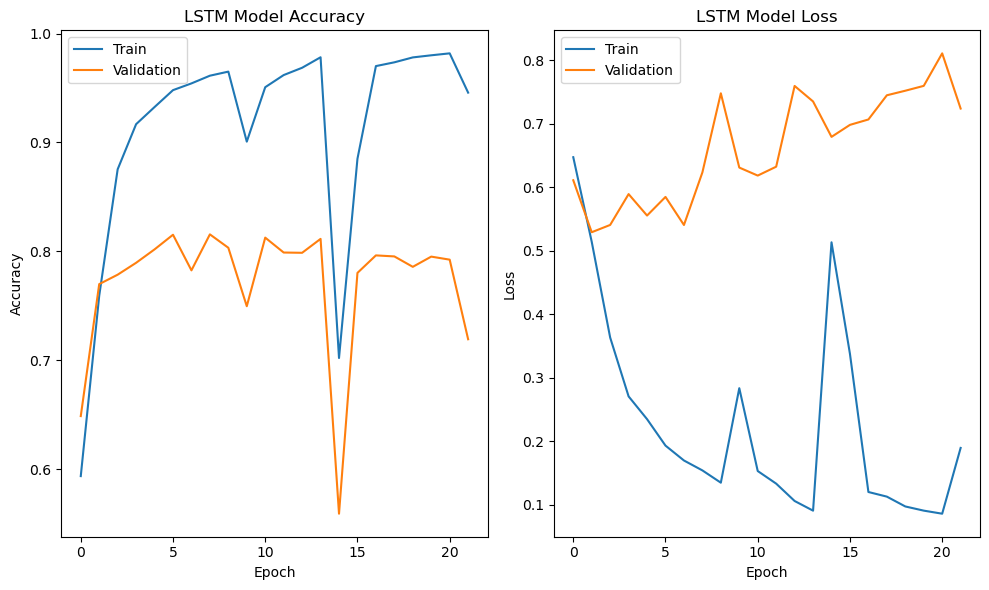

In [951]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()